# Neural Network from scratch

we'll construct a neural network entirely from the ground up. Our implementation will rely on minimal libraries such as numpy, pandas, matplotlib, and sklearn solely for scaling and displaying accuracy metrics. We won't utilize any pre-existing neural network APIs.

We'll proceed to train and evaluate this neural network model on the FASHION-MNIST dataset for image classification.

# import libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import accuracy_score
from statistics import mean

In [2]:
train_data=pd.read_csv('fashion-mnist_train.csv',na_values=['NA','?'])
test_data=pd.read_csv('fashion-mnist_test.csv',na_values=['NA','?'])

In [3]:
train_data.head(10)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
test_data.head

<bound method NDFrame.head of       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0         0       0       0       0       0       0       0       0       9   
1         1       0       0       0       0       0       0       0       0   
2         2       0       0       0       0       0       0      14      53   
3         2       0       0       0       0       0       0       0       0   
4         3       0       0       0       0       0       0       0       0   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
9995      0       0       0       0       0       0       0       0       0   
9996      6       0       0       0       0       0       0       0       0   
9997      8       0       0       0       0       0       0       0       0   
9998      8       0       1       3       0       0       0       0       0   
9999      1       0       0       0       0       0       0       0     140   

      pixel9  ...  pi

In [5]:
train_data.shape

(60000, 785)

In [6]:
X_train = np.array(train_data.loc[:, train_data.columns!='label'])
y_train = pd.get_dummies(train_data["label"]).values.astype(np.float32)

In [7]:
X_test = np.array(test_data.loc[:, test_data.columns!='label'])
y_test = pd.get_dummies(test_data["label"]).values.astype(np.float32)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [9]:
# Scale the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Implement NeuralNetwork Class

In [10]:
class Neural_Network:
     # constructer takes as input: the network size(list of nodes for each layer), list of activation function for each layer
    # learning rate
    def __init__(self,
                network_size,
                activation_fct,
                learning_rate=0.01):
        self.network_size = network_size
        self.activation_fct = activation_fct
        self.learning_rate = learning_rate
        # L: lenght of the network
        self.L = len(network_size)
        self.weight_params = {}
        # list to keep track of costs
        self.costs = []
        # dic for store the value and derivatives and use it inside the class
        self.cache = {}
        # method to initialize the weigths and biases
        self.initialize_weigths()
        
    
    # initialize weights and biases
    def initialize_weigths(self, init_method='xavier'):
        if init_method == 'xavier':
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = np.random.randn(self.network_size[layer], self.network_size[layer + 1]) / np.sqrt(self.network_size[layer])

        elif init_method == 'He':
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = np.random.randn(self.network_size[layer], self.network_size[layer + 1]) / np.sqrt(self.network_size[layer]/2)
        
        else:
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = 2*np.random.random((self.network_size[layer], self.network_size[layer + 1])) - 1
                
    
    # activation functions and there derivatives
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivation(self, x):
        return x * (1-x)

    def ReLU(self, x):
        return np.maximum(0,x)

    def ReLU_derivation(self, x):
        return 1.0*(x>0)

    def softmax(self, s):
        exps = np.exp(s - np.max(s, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)
    
    # cross entropy and error to use it with softmax in output layer
    def cross_entropy(self, pred, real):
        n_samples = real.shape[0]
        res = pred - real
        return res/n_samples
    
    def error(self, yHat, y):
        cost = -np.mean(y * np.log(yHat + 1e-8))
        return cost
    
    # method takes as input X, y, batch_size and seeds, to return mini_batchs according to the size of batchs, and use the seeds
    # to get every time diffrenet batchs
    def get_minibatches_train(self, X, y, batch_size, seeds):
        size_split = int(len(X)/batch_size)
        mini_batches = []
        indexes = np.arange(len(X))
        np.random.seed(seeds)
        np.random.shuffle(indexes)

        for i in range(size_split):

            X_mini = X[indexes[i * batch_size: (i+1) * batch_size]]
            y_mini = y[indexes[i * batch_size: (i+1) * batch_size]]
            mini_batch = (X_mini, y_mini)
            mini_batches.append(mini_batch)

        return mini_batches
    
    # Feedforward method, takes as input the values of X
    def _feedforward(self, X):
        
        # initialize value small x as big X, so we can use it in the loop and update it to calculate z and a
        x = X
        
        # test the loop and make sure it creates the correct value of z and a
        """
        for layer in range(1, self.L - 1):
            print(f'z{layer} = {x} * w{layer}')
            if self.activation_fct[layer - 1] == 'ReLU':
                print(f'a{layer} = ReLU(z{layer})')
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                print(f'a{layer} = sigmoid(z{layer})')
            
            
            x = f'a{layer}'
                
        """
        # Loop over the number of layer, except the last layer, because we're using softmax since it is a classification
        for layer in range(1, self.L - 1):
            # z = x.w + b
            self.cache[f'z{layer}'] = np.dot(x, self.weight_params[f'w{layer}']) + self.weight_params[f'b{layer}']
            
            # check the activation function
            # a = activation(z)
            
            if self.activation_fct[layer - 1] == 'ReLU':
                self.cache[f'a{layer}'] = self.ReLU(self.cache[f'z{layer}'])
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                self.cache[f'a{layer}'] = self.sigmoid(self.cache[f'z{layer}'])
            
            # update the value of x to be x = a
            x = self.cache[f'a{layer}']
            
        # Now calculate the z and a to the last layer using softmax, so we will get propability distribution between 0 and 1
        self.cache[f'z{self.L - 1}'] = np.dot(x, self.weight_params[f'w{self.L - 1}']) + self.weight_params[f'b{self.L - 1}']
        self.cache[f'a{self.L - 1}'] = self.softmax(self.cache[f'z{self.L - 1}'])
        
        
        # return the last value of a, so it's the output of softmax, in other words, yHat or predicted y
        return self.cache[f'a{self.L - 1}']
    
    # backward function takes as inputs X and y
    def _backward(self, X, y):
        
        # test the loop and make sure it creates the correct value of z_delta and a_delta
        """
        for layer in range(self.L - 2, 0, -1):
            print(f'z{layer}_delta = a{layer + 1}_delta * w{layer+1}.T')
            
            print(self.activation_fct[layer-1])
            if self.activation_fct[layer-1] == 'ReLU':
                print(f'a{layer}_delta = z{layer}_delta * dev_ReLU(a{layer})')
                
            elif self.activation_fct[layer-1] == 'sigmoid':
                print(f'a{layer}_delta = z{layer}_delta * dev_sigmoid(a{layer})')
        
        
        """
        #print(cache[f'a{self.L - 1}'])
        #loss = self.error(self.cache[f'a{self.L - 1}'], y)
        
        self.cache[f'a{self.L - 1}_delta'] = self.cross_entropy(self.cache[f'a{self.L - 1}'], y)
        self.cache[f'z{self.L - 1}_delta'] = self.cross_entropy(self.cache[f'z{self.L - 1}'], y)
        
        for layer in range(self.L - 2, 0, -1):
            #print(layer)
            self.cache[f'z{layer}_delta'] = np.dot( self.cache[f'a{layer + 1}_delta'], self.weight_params[f'w{layer+1}'].T)
            
            #print(self.activation_fct[layer - 1])
            if self.activation_fct[layer - 1] == 'ReLU':
                self.cache[f'a{layer}_delta'] = self.cache[f'z{layer}_delta'] * self.ReLU_derivation(self.cache[f'a{layer}'])
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                self.cache[f'a{layer}_delta'] = self.cache[f'z{layer}_delta'] * self.sigmoid_derivation(self.cache[f'a{layer}'])

        #print(self.cache.keys())
        
    # Method to fit the data, takes as input X, y, number of epochs, print epochs every loss_every, optimizer method, and batch_size
    def fit(self, X, y, nb_epochs = 500, loss_every=50, optimizer='GD', stop=0.02,batch_size=None):
        
        # if batch_size not given, then it's a normal gradient descent
        # if it is > len(X) so batch_size = len(X) and if < 0 fo it's = 1,(SGD)
        if batch_size == None:
            batch_size = len(X)
        
        if batch_size > len(X):
            batch_size = len(X)
        
        if batch_size <= 1:
            batch_size = 1
        
        if optimizer == 'GD':
            for epoch in range(nb_epochs):
                
                mini_batches = self.get_minibatches_train(X, y, batch_size, epoch)
                mini_batch_cost = []
                
                # for every batch in mini_batchs run forward and backward and update the weights and biases
                for mini_batch in mini_batches:
                    X_batch, y_batch = mini_batch
                    yHat = self._feedforward(X_batch)
                    self._backward(X_batch, y_batch) 
                    loss = self.error(yHat, y_batch)
                    a = X_batch.T
                    
                    # m is the number of samples
                    m = X_batch.shape[0]
                    
                    # int(len(self.weight_params)/2) is the number of w and b to update
                    for layer in range(1, int(len(self.weight_params)/2)):
                        
                        self.weight_params[f'w{layer}'] -= self.learning_rate  * np.dot(a, self.cache[f'a{layer}_delta'])
                        self.weight_params[f'b{layer}'] -= self.learning_rate  * np.sum(self.cache[f'z{layer}_delta'], axis = 0, keepdims = True)
                        a = self.cache[f'a{layer}'].T
                    
                    # append the loss to the cost list and to mini_batchs_cost to stop it accourding to stoping creteria
                    mini_batch_cost.append(loss)
                    self.costs.append(loss)
                
                
                #self.costs.append(mean(mini_batch_cost))
                
                # print loss 
                if epoch % loss_every == 0:
                        #print(f'epoch {epoch}: |||| Loss = {round(mean(mini_batch_cost), 5)}')
                        print("Epoch: {} - Loss:{:.4f}".format(epoch, mean(mini_batch_cost)))
                        print('=======================================================================')
                
                # check the loss and stop teh network if loss less then stop, default = 0.02
                if mean(mini_batch_cost) < stop:
                    break
        
        """
        for epoch in range(nb_epochs):
            
            yHat = self._feedforward(X)
            #print(self.error(yHat, y))
            self._backward(X, y) 
            
            loss = self.error(yHat, y)
            
            a = X.T
            for layer in range(1, len(self.weight_params)):
                self.weight_params[f'w{layer}'] -= self.learning_rate * np.dot(a, self.cache[f'a{layer}_delta'])
                a = self.cache[f'a{layer}'].T
            
            if epoch % loss_every == 0:
                print(f'epoch {epoch}: {loss}')
                
            self.costs.append(loss)
         """       
        
    # predict method return yHat
    def predict(self, X):
        yHat = self._feedforward(X)
        yHat = np.argmax(yHat, axis=1)
        return yHat
    
    # method to check accuracy
    def check_accuracy(self, y, yHat):
        y_true = np.argmax(y, axis=1)
        score = accuracy_score(y_true, yHat)
        return score * 100
    
    # plot the costs
    def plot_cost(self, title, xlabel='epochs'):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel(xlabel)
        plt.ylabel("cost")
        plt.title(title)
        plt.show()
        
    
    def model_summary(self):
        print(f"Input features = {self.network_size[0]} \nOutput labels = {self.network_size[-1]}\n")
        for layer in range(len(self.activation_fct)):
            
            if layer == len(self.activation_fct):
                print(f"Output Layer {layer} \nNumber of nodes = {self.network_size[layer + 1]} \nActivation function: {self.activation_fct[layer]}")
            
            else:
                print(f"Hidden Layer {layer} \nNumber of nodes = {self.network_size[layer + 1]} \nweight shape: {self.weight_params[f'w{layer + 1}'].shape} \nBias Shape {self.weight_params[f'b{layer + 1}'].shape} \nActivation function: {self.activation_fct[layer]}\n")
    
        
#     # method to print the images with the prediction and if its true or false
#     def plot_images_with_prediction(self, test_data, y_test, yHat):
#         images = test_data.drop("label", axis=1).values
#         images = np.reshape(images,(10000,28,28))
#         y_real = np.argmax(y_test, axis=1)
#         label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#         ytest = test_data.label.values
#         plt.figure(figsize=(15,15))
#         random1 = random.randint(0, test_data.shape[0] - 26)
#         for i in range(random1, random1+24):
#             plt.subplot(5,5,int(i+1))
#             plt.xticks([]) 
#             plt.yticks([]) 
#             plt.grid(False) 
            
#             plt.imshow(images[i],cmap='gray')
#             if yHat[i] == y_real[i]: 
#                 plt.xlabel(f'TRUE: {label_names[yHat[i]]}', c='b')
#             else:
#                 plt.xlabel(f'False: {label_names[ytest[i]]}-{label_names[yHat[i]]}', c='r')

#         plt.show()

    def plot_images_with_prediction(self, test_data, y_test, yHat):
        images = test_data.drop("label", axis=1).values
        images = np.reshape(images,(10000,28,28))
        y_real = np.argmax(y_test, axis=1)
        label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        ytest = test_data.label.values
        plt.figure(figsize=(15,15))
        random1 = random.randint(0, test_data.shape[0] - 26)
        for i in range(24):  # Adjusted loop range
            plt.subplot(5,5,i+1)  # Removed the addition of random1 to i
            plt.xticks([]) 
            plt.yticks([]) 
            plt.grid(False) 
            
            plt.imshow(images[random1 + i], cmap='gray')  # Adjusted indexing to use random1
            if yHat[random1 + i] == y_real[random1 + i]: 
                plt.xlabel(f'TRUE: {label_names[yHat[random1 + i]]}', c='b')
            else:
                plt.xlabel(f'False: {label_names[ytest[random1 + i]]}-{label_names[yHat[random1 + i]]}', c='r')

        plt.show()

                   

# Fit the Model with 1 hidden layer with 500 nodes and Sigmoid activation

In [11]:
network_size = [784, 500, 10]
activation_fct = ['sigmoid', 'softmax']
nn0 = Neural_Network(network_size, activation_fct)
nn0.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: sigmoid

Hidden Layer 1 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [12]:
nn0.fit(X_train, y_train, nb_epochs = 100 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.2532
Epoch: 5 - Loss:0.2515
Epoch: 10 - Loss:0.2499
Epoch: 15 - Loss:0.2484
Epoch: 20 - Loss:0.2470
Epoch: 25 - Loss:0.2457
Epoch: 30 - Loss:0.2444
Epoch: 35 - Loss:0.2432
Epoch: 40 - Loss:0.2420
Epoch: 45 - Loss:0.2409
Epoch: 50 - Loss:0.2398
Epoch: 55 - Loss:0.2387
Epoch: 60 - Loss:0.2377
Epoch: 65 - Loss:0.2368
Epoch: 70 - Loss:0.2358
Epoch: 75 - Loss:0.2349
Epoch: 80 - Loss:0.2341
Epoch: 85 - Loss:0.2332
Epoch: 90 - Loss:0.2324
Epoch: 95 - Loss:0.2316


Accuracy Score:  13.16 %


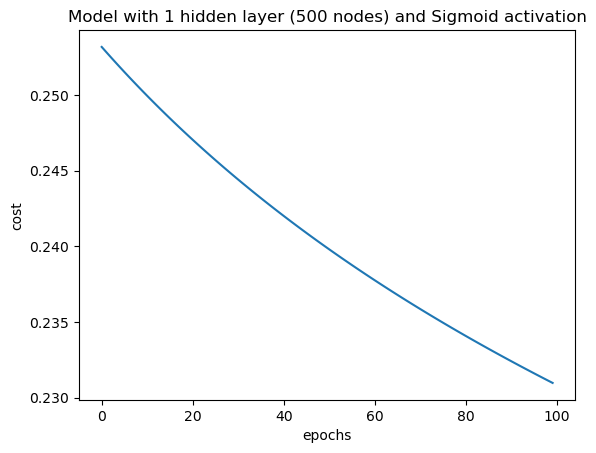

In [13]:
yHat = nn0.predict(X_test)
print('Accuracy Score: ', nn0.check_accuracy(y_test, yHat), '%')
nn0.plot_cost(title='Model with 1 hidden layer (500 nodes) and Sigmoid activation')

# Fit the Model with 1 hidden layer with 500 nodes and ReLU activation

In [14]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn1 = Neural_Network(network_size, activation_fct, learning_rate=0.1)
nn1.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [15]:
nn1.fit(X_train, y_train, nb_epochs = 100 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.2623
Epoch: 5 - Loss:0.1658
Epoch: 10 - Loss:0.1351
Epoch: 15 - Loss:0.1187
Epoch: 20 - Loss:0.1086
Epoch: 25 - Loss:0.1016
Epoch: 30 - Loss:0.0964
Epoch: 35 - Loss:0.0924
Epoch: 40 - Loss:0.0892
Epoch: 45 - Loss:0.0865
Epoch: 50 - Loss:0.0842
Epoch: 55 - Loss:0.0822
Epoch: 60 - Loss:0.0804
Epoch: 65 - Loss:0.0789
Epoch: 70 - Loss:0.0775
Epoch: 75 - Loss:0.0762
Epoch: 80 - Loss:0.0751
Epoch: 85 - Loss:0.0740
Epoch: 90 - Loss:0.0731
Epoch: 95 - Loss:0.0722


Accuracy Score:  77.64999999999999


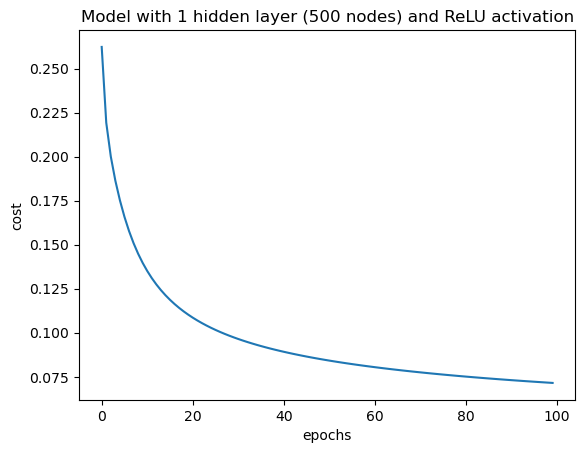

In [16]:
yHat = nn1.predict(X_test)
print('Accuracy Score: ', nn1.check_accuracy(y_test, yHat))
nn1.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation')

In [17]:
nn1.fit(X_train, y_train, nb_epochs = 500 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.0714
Epoch: 5 - Loss:0.0706
Epoch: 10 - Loss:0.0699
Epoch: 15 - Loss:0.0692
Epoch: 20 - Loss:0.0685
Epoch: 25 - Loss:0.0679
Epoch: 30 - Loss:0.0674
Epoch: 35 - Loss:0.0668
Epoch: 40 - Loss:0.0663
Epoch: 45 - Loss:0.0659
Epoch: 50 - Loss:0.0654
Epoch: 55 - Loss:0.0650
Epoch: 60 - Loss:0.0645
Epoch: 65 - Loss:0.0641
Epoch: 70 - Loss:0.0637
Epoch: 75 - Loss:0.0634
Epoch: 80 - Loss:0.0630
Epoch: 85 - Loss:0.0627
Epoch: 90 - Loss:0.0623
Epoch: 95 - Loss:0.0620
Epoch: 100 - Loss:0.0617
Epoch: 105 - Loss:0.0614
Epoch: 110 - Loss:0.0611
Epoch: 115 - Loss:0.0609
Epoch: 120 - Loss:0.0606
Epoch: 125 - Loss:0.0603
Epoch: 130 - Loss:0.0601
Epoch: 135 - Loss:0.0598
Epoch: 140 - Loss:0.0596
Epoch: 145 - Loss:0.0594
Epoch: 150 - Loss:0.0592
Epoch: 155 - Loss:0.0589
Epoch: 160 - Loss:0.0587
Epoch: 165 - Loss:0.0585
Epoch: 170 - Loss:0.0583
Epoch: 175 - Loss:0.0581
Epoch: 180 - Loss:0.0580
Epoch: 185 - Loss:0.0578
Epoch: 190 - Loss:0.0576
Epoch: 195 - Loss:0.0574
Epoch: 200 - Loss:0.05

Epoch: 425 - Loss:0.0523
Epoch: 430 - Loss:0.0522
Epoch: 435 - Loss:0.0521
Epoch: 440 - Loss:0.0521
Epoch: 445 - Loss:0.0520
Epoch: 450 - Loss:0.0519
Epoch: 455 - Loss:0.0518
Epoch: 460 - Loss:0.0518
Epoch: 465 - Loss:0.0517
Epoch: 470 - Loss:0.0516
Epoch: 475 - Loss:0.0516
Epoch: 480 - Loss:0.0515
Epoch: 485 - Loss:0.0514
Epoch: 490 - Loss:0.0514
Epoch: 495 - Loss:0.0513


Accuracy Score:  83.15


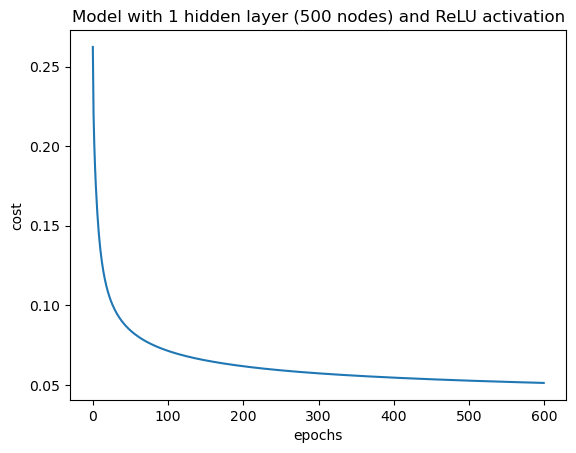

In [18]:
yHat = nn1.predict(X_test)
print('Accuracy Score: ', nn1.check_accuracy(y_test, yHat))
nn1.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation')

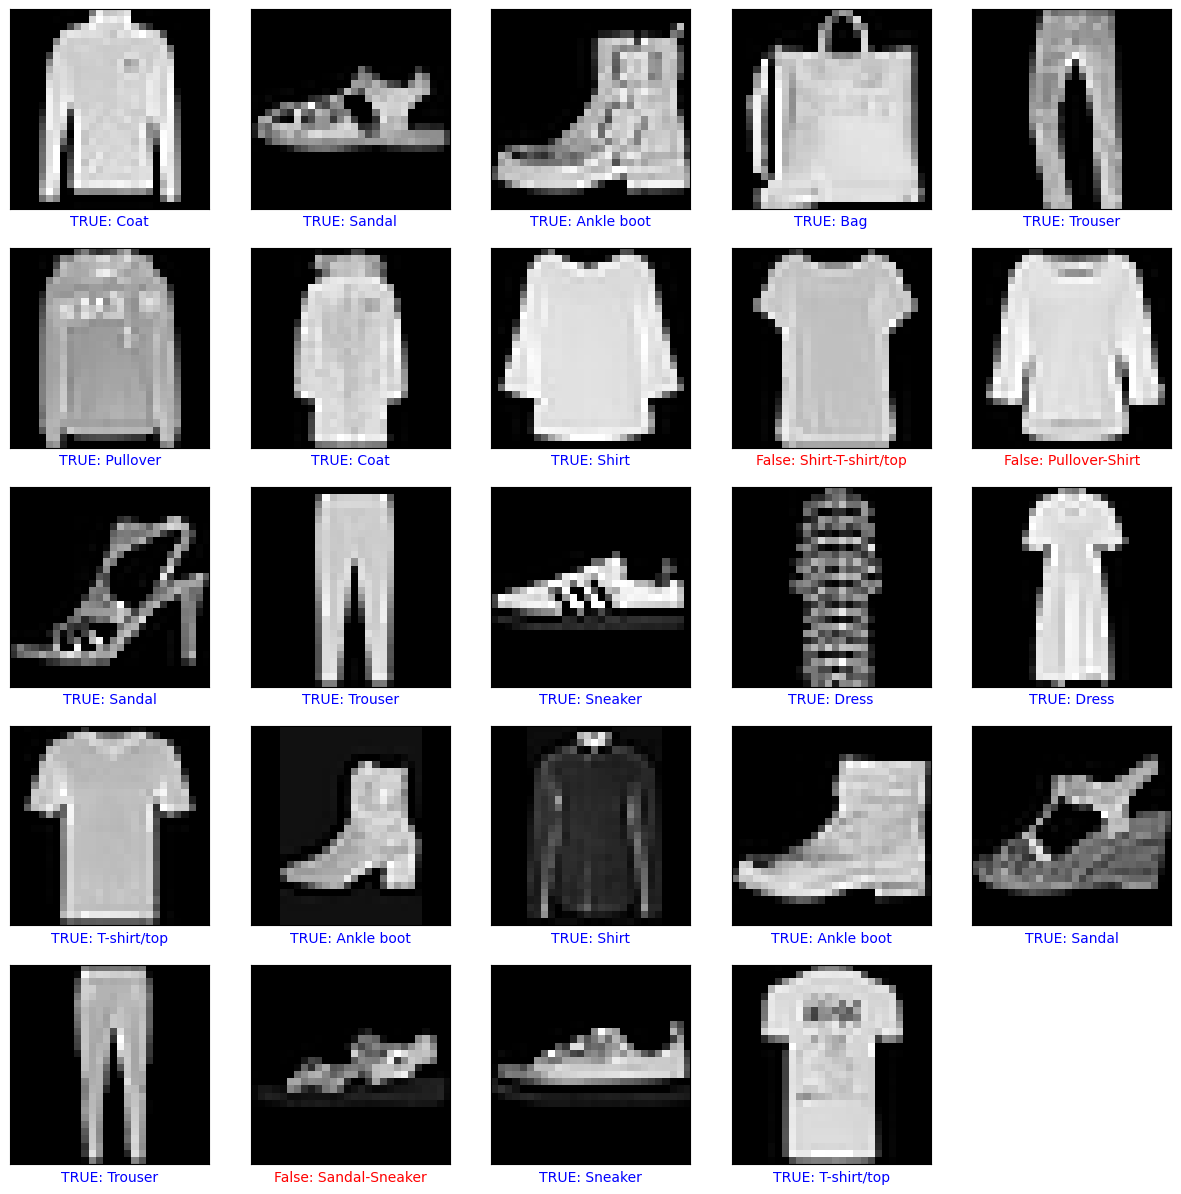

In [19]:
nn1.plot_images_with_prediction(test_data, y_test, yHat)

# Fit the Model with 1 hidden layer with 500, ReLU activation function and mini batch as oprimazation

In [20]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn2 = Neural_Network(network_size, activation_fct, learning_rate=0.1)

In [21]:
nn2.fit(X_train, y_train, nb_epochs = 100, loss_every=50, batch_size = 100, stop=0.025)

Epoch: 0 - Loss:0.0681
Epoch: 50 - Loss:0.0318


Accuracy Score:  88.07000000000001


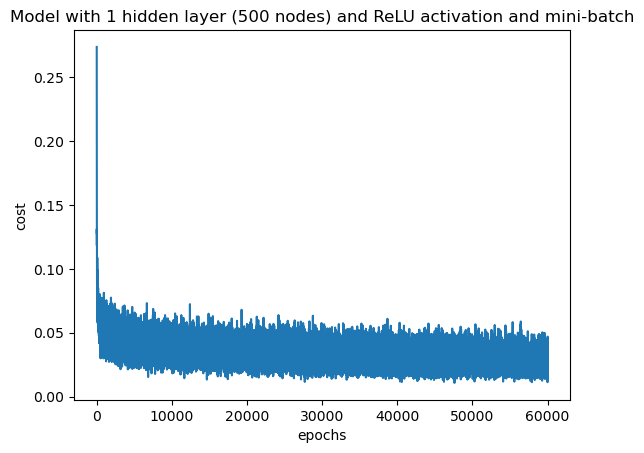

In [22]:
yHat = nn2.predict(X_test)
print('Accuracy Score: ', nn2.check_accuracy(y_test, yHat))
nn2.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation and mini-batch')

# Fit the Model with 1 hidden layer with 500 nodes, ReLU activation function with SGD

In [23]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn3 = Neural_Network(network_size, activation_fct)

Accuracy Score:  9.959999999999999


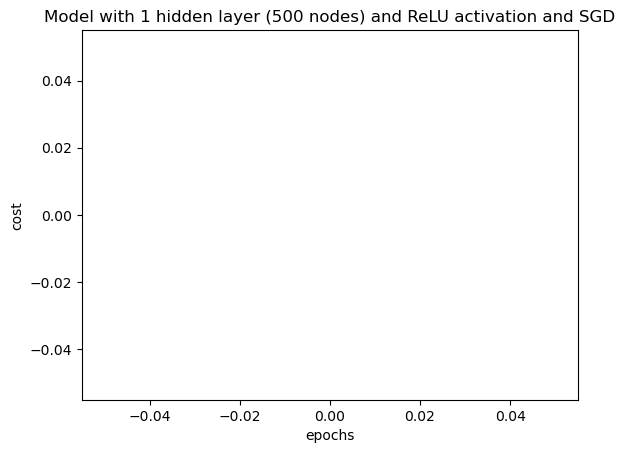

In [24]:
yHat = nn3.predict(X_test)
print('Accuracy Score: ', nn3.check_accuracy(y_test, yHat))
nn3.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation and SGD')

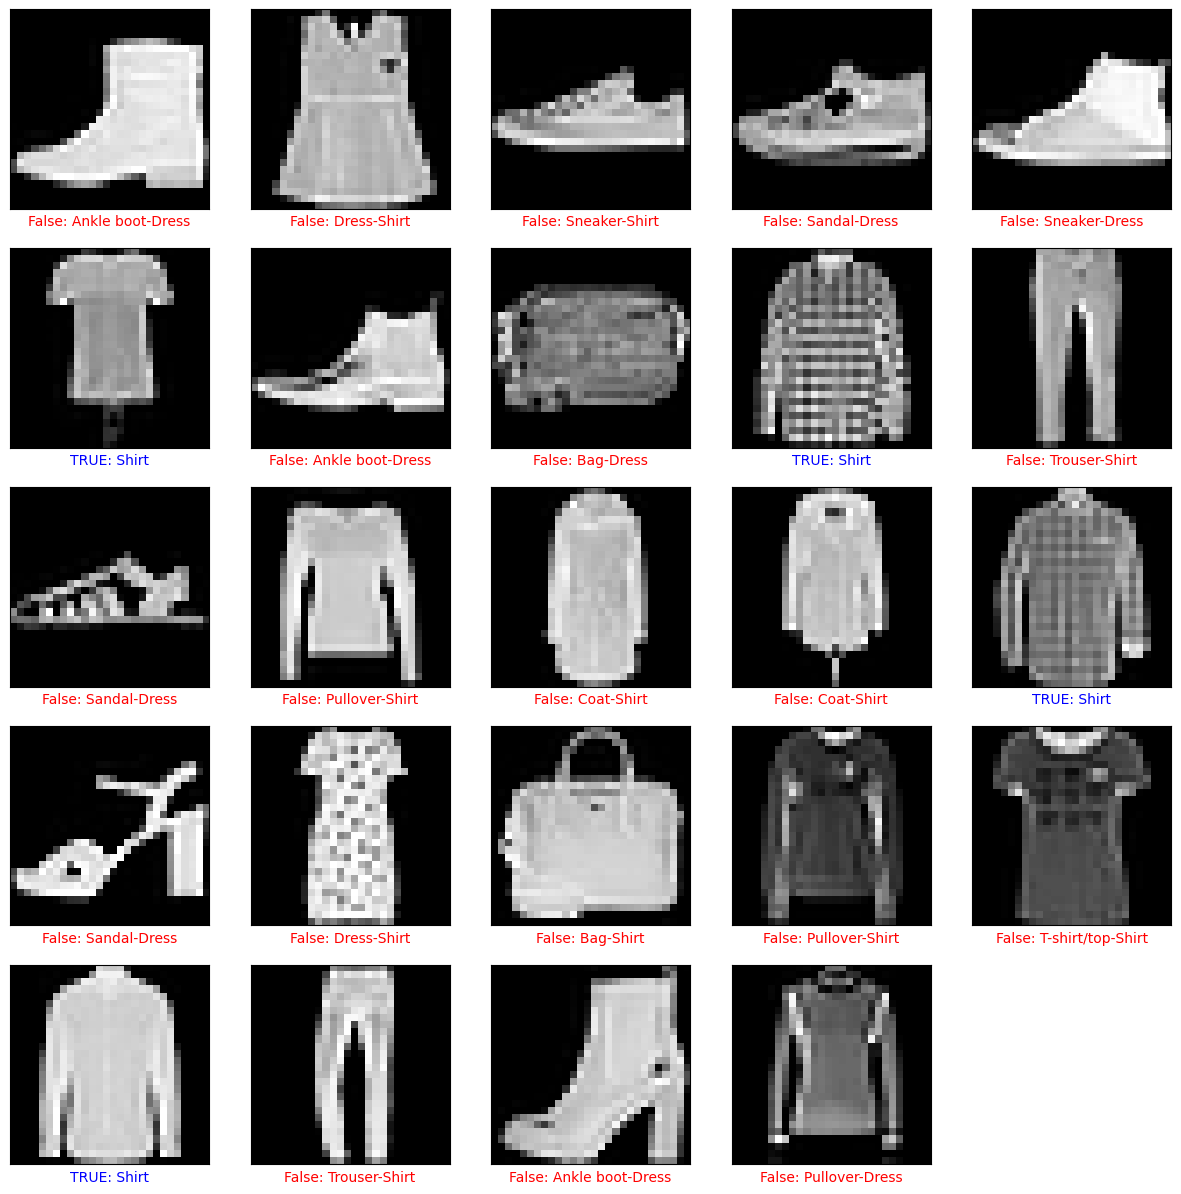

In [25]:
nn3.plot_images_with_prediction(test_data, y_test, yHat)

# Fit the Model with 2 hidden layer with 500 and 500 nodes, ReLU activation function with mini-batchs

In [26]:

network_size = [784, 500, 500,  10]
activation_fct = ['ReLU', 'ReLU', 'softmax']
nn4 = Neural_Network(network_size, activation_fct, learning_rate=0.1)
nn4.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 500 
weight shape: (500, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 2 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [27]:
nn4.fit(X_train, y_train, nb_epochs = 500, loss_every=10, batch_size = 100, stop=0.025)

Epoch: 0 - Loss:0.0662
Epoch: 10 - Loss:0.0310
Epoch: 20 - Loss:0.0255


Accuracy Score:  88.83


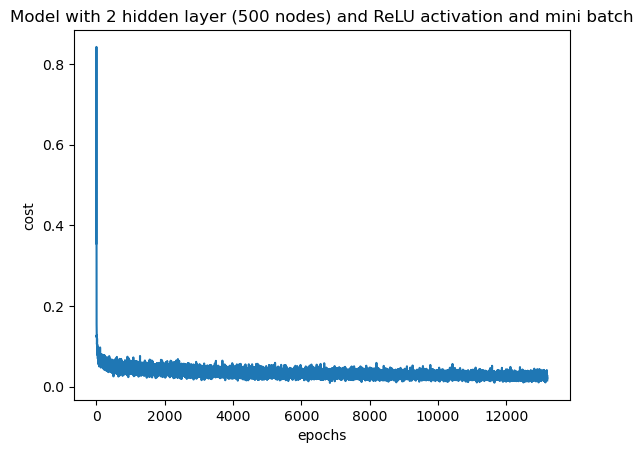

In [28]:
yHat = nn4.predict(X_test)
print('Accuracy Score: ', nn4.check_accuracy(y_test, yHat))
nn4.plot_cost(title='Model with 2 hidden layer (500 nodes) and ReLU activation and mini batch')

In [29]:
network_size = [784, 500, 500,  10]
activation_fct = ['ReLU', 'ReLU', 'softmax']
nn5 = Neural_Network(network_size, activation_fct, learning_rate=0.1)
nn5.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 500 
weight shape: (500, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 2 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [30]:
nn5.fit(X_train, y_train, nb_epochs = 500, loss_every=10, batch_size = 100, stop=0.02)

Epoch: 0 - Loss:0.0644
Epoch: 10 - Loss:0.0312
Epoch: 20 - Loss:0.0257
Epoch: 30 - Loss:0.0218


Accuracy Score:  89.74


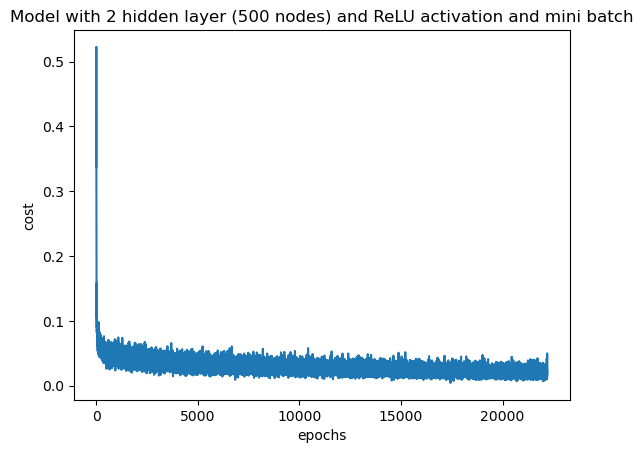

In [31]:
yHat = nn5.predict(X_test)
print('Accuracy Score: ', nn5.check_accuracy(y_test, yHat))
nn5.plot_cost(title='Model with 2 hidden layer (500 nodes) and ReLU activation and mini batch')

In [32]:
# model 0
yHat0 = nn0.predict(X_test)
accuracy_0 = nn0.check_accuracy(y_test, yHat0)

# model 1
yHat1 = nn1.predict(X_test)
accuracy_1 = nn1.check_accuracy(y_test, yHat1)

# model 2
yHat2 = nn2.predict(X_test)
accuracy_2 = nn2.check_accuracy(y_test, yHat2)

# model 3
yHat3 = nn3.predict(X_test)
accuracy_3 = nn3.check_accuracy(y_test, yHat3)

# model 4
yHat4 = nn4.predict(X_test)
accuracy_4 = nn4.check_accuracy(y_test, yHat4)

# model 5
yHat5 = nn2.predict(X_test)
accuracy_5 = nn5.check_accuracy(y_test, yHat5)

accuracy = [accuracy_0, accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5]
models = ['sigmoid act', 'ReLU act', 'ReLU mini-batch', 'ReLU SGD', '2 hidden layers minibatch', 'model 4 change stopping']

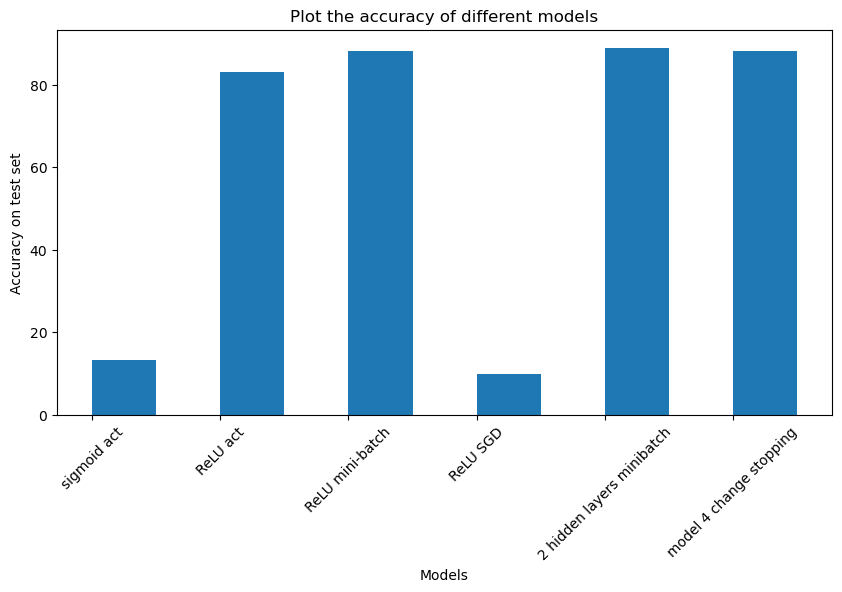

In [33]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(models, accuracy, align='edge', width = 0.5)
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Accuracy on test set")
plt.title("Plot the accuracy of different models")
plt.show()